# Faster R-CNN for SoccerNet

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from utils import *
from model import *
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [4]:

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using MPS (Apple Silicon GPU)


### Load Images

**Note:** The annotations should also contain the corresponding image path

In [5]:
img_width = 1920
img_height = 1080
image_dir = os.path.join("..", "soccernet_data", "tracking", "train", "SNMOT-060")

#### Create Dataset and Dataloaders

In [6]:
from data_loader import SoccerDatasetSequence, get_dataloader


batch_size = 3 
num_images_to_display = 2

od_dataloader = get_dataloader(
    sequence_dir=image_dir, 
    img_size=(img_height, img_width), 
    batch_size=batch_size, 
    shuffle=False # Keep shuffle=False if you want the *first* sequence elements
)

# Sample batch
img_data_all, gt_bboxes_all, gt_classes_all = next(iter(od_dataloader))
gt_classes_all

tensor([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         -1, -1, -1, -1, -1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         -1, -1, -1, -1, -1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         -1, -1, -1, -1, -1]])

### Display Images and Bounding Boxes

In [7]:
# get class names
ground_truth_dummy_classes = gt_classes_all[0].long()
ground_truth_dummy_classes = ["player" for idx in ground_truth_dummy_classes]

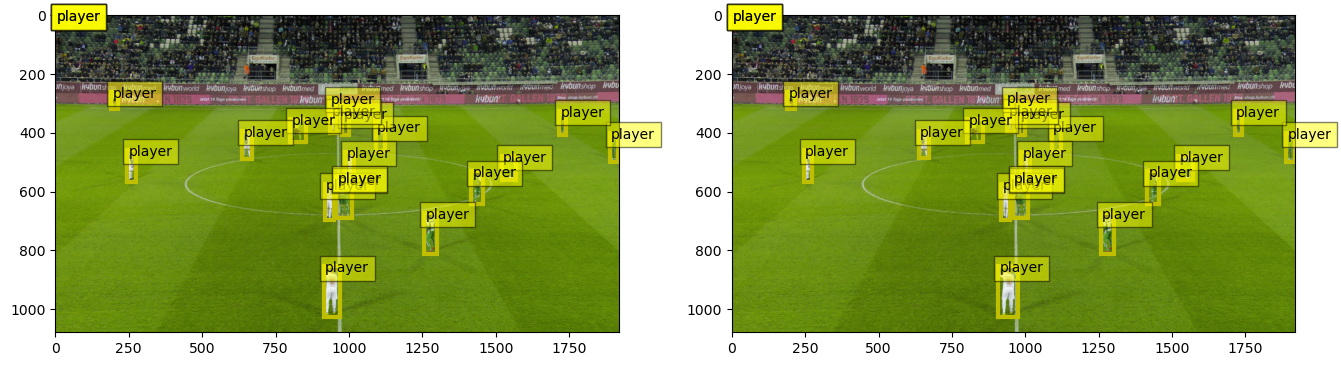

In [8]:

nrows, ncols = (1, num_images_to_display)

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all[:num_images_to_display], fig, axes)

for i in range(num_images_to_display):
    fig, _ = display_bbox(gt_bboxes_all[i], fig, axes[i], classes=ground_truth_dummy_classes)

## Inception v3 Feature Extractor

In [9]:
from featureExtractor import InceptionFeatureExtractor

backbone = InceptionFeatureExtractor()
out = backbone(img_data_all)
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)
print('Out dims:', out_c, out_h, out_w)

width_scale_factor = img_width // out_w
height_scale_factor = img_height / out_h
print(img_width, img_height, '->', out_w, out_h)


height_scale_factor, width_scale_factor

Out dims: 2048 32 58
1920 1080 -> 58 32


(33.75, 33)

### Visualize 1st channel of feature map

(np.float64(-0.5), np.float64(57.5), np.float64(31.5), np.float64(-0.5))

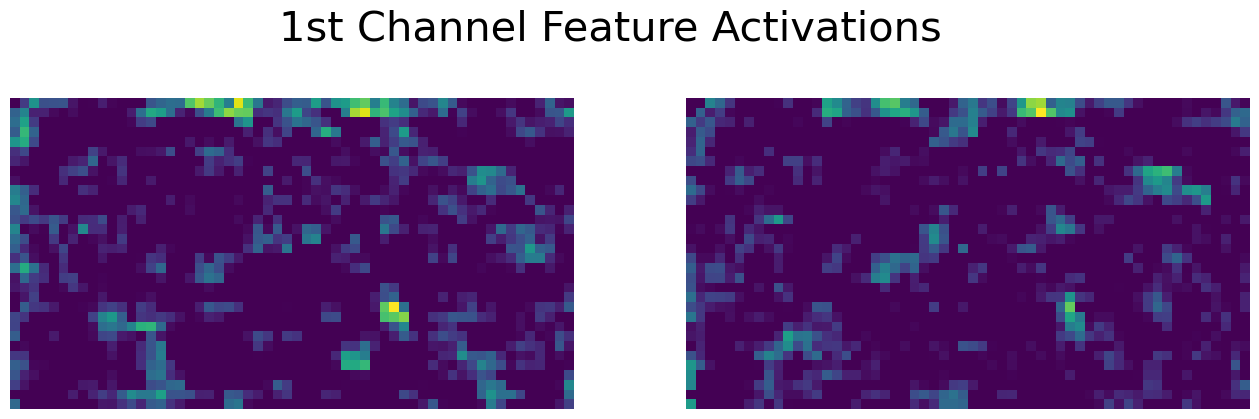

In [10]:
nrows, ncols = (1, num_images_to_display)
fig, axes = plt.subplots(nrows, num_images_to_display, figsize=(16, 8))
fig.suptitle(f"1st Channel Feature Activations", fontsize=30, y=.80)
filters_data =[filters[0].detach().numpy() for filters in out[:2]]
fig, axes = display_img(filters_data, fig, axes)

axes[0].axis('off')
axes[1].axis('off')

### Visualize all channels of feature map

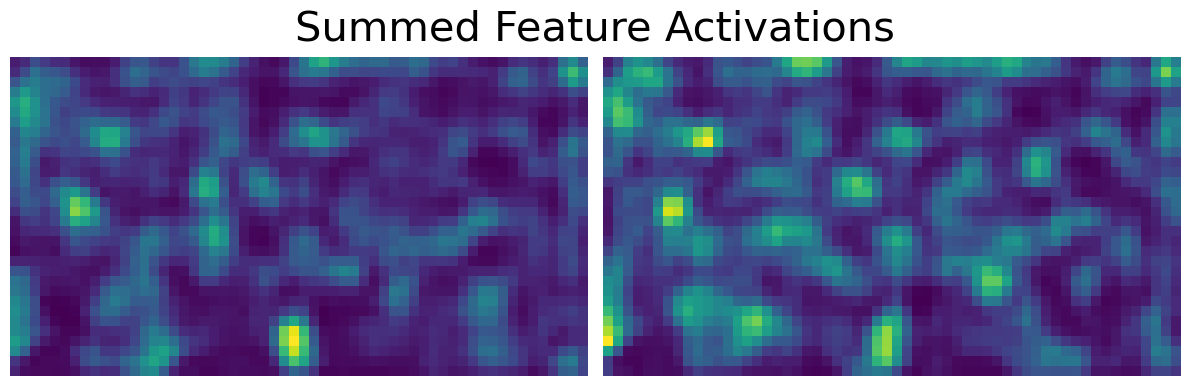

In [11]:
image_index_to_show = 0  # Choose which image from the batch to visualize

fig, axes = plt.subplots(1, num_images_to_display, figsize=(12, 6))
fig.suptitle(f"Summed Feature Activations", fontsize=30, y=.80)

for i in range(num_images_to_display):
    axes[i].axis('off')
    feature_map_single = out[i]
    activation_map_summed = feature_map_single.sum(dim=0)
    activation_map_np = activation_map_summed.detach().cpu().numpy()
    axes[i].imshow(activation_map_np, cmap='viridis')

plt.tight_layout()
plt.show()


### Generate and Plot Anchor Points, Sample Boxes

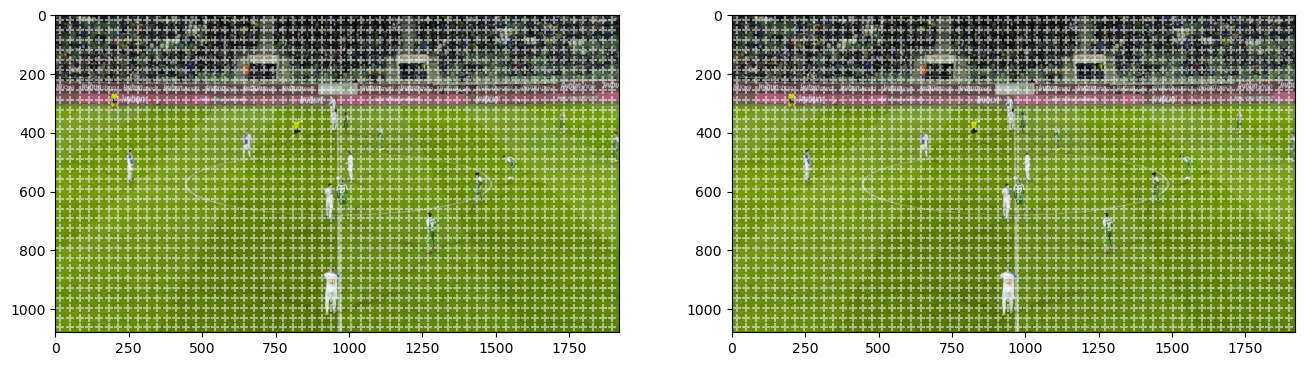

In [12]:
anc_pts_x, anc_pts_y = gen_anc_centers((out_h, out_w), device)

# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor 
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor


# Visualization
nrows, ncols = (1, num_images_to_display)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
fig, axes = display_img(img_data_all[:num_images_to_display], fig, axes)
for i in range(num_images_to_display):
    fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[i])

# Create Anchor Boxes around Anchor points
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios) 
anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w), device)
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)

### plot anchor boxes on a single anchor point

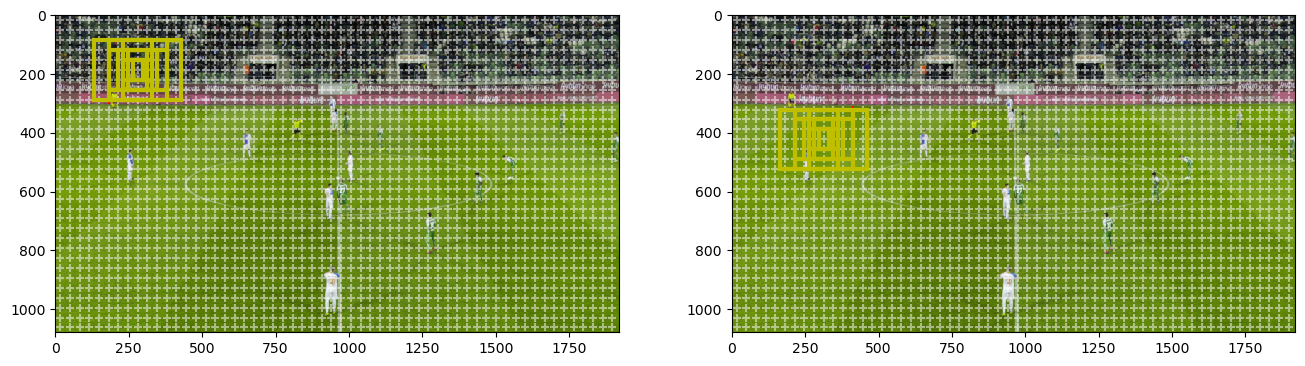

In [13]:
nrows, ncols = (1, num_images_to_display)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
fig, axes = display_img(img_data_all[:num_images_to_display], fig, axes)
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# selected anchor points
sp = [[5, 8],[12, 9], [25,20]]

for i in range(num_images_to_display):
    sp_i = sp[i]
    bboxes_i = anc_boxes_proj[i][sp_i[0], sp_i[1]]
    fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[i], (anc_pts_x_proj[sp_i[0]], anc_pts_y_proj[sp_i[1]]))
    fig, _ = display_bbox(bboxes_i, fig, axes[i])

### plot all anchor boxes

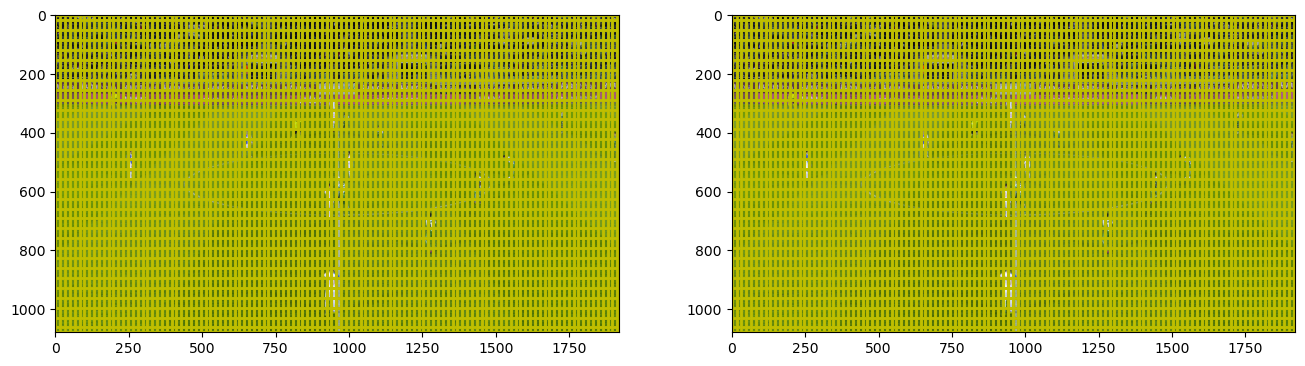

In [14]:
nrows, ncols = (1, num_images_to_display)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
img_data_cpu = img_data_all[:num_images_to_display].cpu()
fig, axes = display_img(img_data_cpu, fig, axes)

anc_pts_x_proj_cpu = anc_pts_x_proj.cpu()
anc_pts_y_proj_cpu = anc_pts_y_proj.cpu()
anc_boxes_proj_cpu = anc_boxes_proj.cpu()

for x in range(anc_pts_x_proj_cpu.size(dim=0)):
    for y in range(anc_pts_y_proj_cpu.size(dim=0)):
       
        bboxes = anc_boxes_proj_cpu[0][y, x]
        for i in range(num_images_to_display):
            display_bbox(bboxes, fig, axes[i], line_width=1)

plt.show()

### Get Positive and Negative Anchors

In [15]:
pos_thresh = 0.7
neg_thresh = 0.3

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a')

positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, GT_class_pos, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes_all, device, pos_thresh, neg_thresh)

#### Visualize positive anchor coordinates

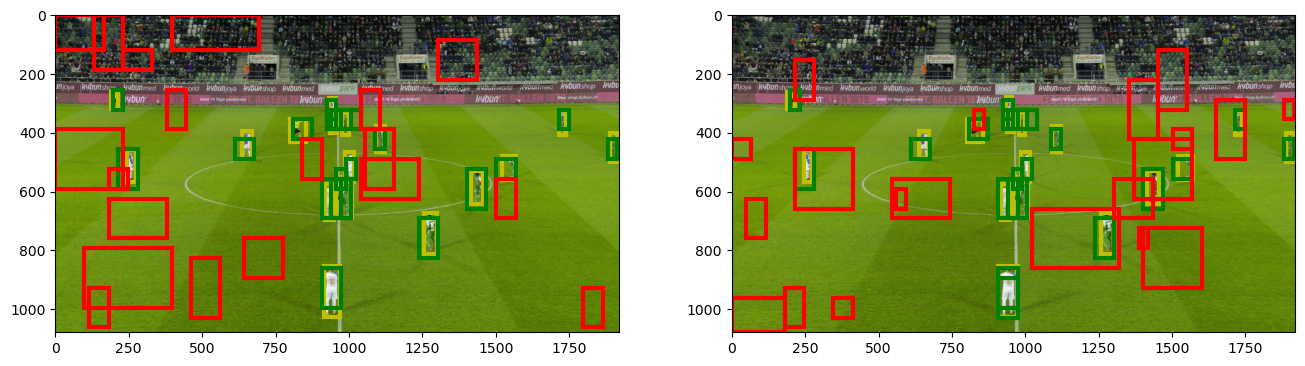

In [16]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately
fig, axes = plt.subplots(nrows, num_images_to_display, figsize=(16, 8))
fig, axes = display_img(img_data_all[:num_images_to_display], fig, axes)

anc_idx = [] 
pos_anc = []
neg_anc = []
for i in range(num_images_to_display):
    anc_idx.append(torch.where(positive_anc_ind_sep == i)[0])
    pos_anc.append(pos_anc_proj[anc_idx[i]])
    neg_anc.append(neg_anc_proj[anc_idx[i]])

    #display ground truth bboxes
    fig, _ = display_bbox(gt_bboxes_all[i], fig, axes[i])
    #display positive anchor boxes
    fig, _ = display_bbox(pos_anc[i], fig, axes[i], color='g')
    #display negative anchor boxes
    fig, _ = display_bbox(neg_anc[i], fig, axes[i], color='r')

### Building the model

In [17]:
img_size = (img_height, img_width)
out_size = (out_h, out_w)
out_channels = out_c
roi_size = (2, 2)
n_classes = 1
# (img_size, out_channels, n_classes, roi_size)
detector = TwoStageDetector(img_size, out_channels, n_classes, roi_size)

/opt/anaconda3/envs/ML_FinalProj/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/ML_FinalProj/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:

detector.to(device)
detector.eval() 

# Move data to the selected device
img_data_all_dev = img_data_all.to(device)
gt_bboxes_all_dev = gt_bboxes_all.to(device)
gt_classes_all_dev = gt_classes_all.long().to(device) # Ensure long type and device

with torch.no_grad(): # Use no_grad for evaluation/inference
    total_loss = detector(img_data_all_dev, gt_bboxes_all_dev, gt_classes_all_dev, device=device)
    proposals_final, conf_scores_final, classes_final = detector.inference(img_data_all_dev, device=device)

print(f"Total Loss (Evaluation): {total_loss.item()}")


Total Loss (Evaluation): 69.56966400146484


### Training loop

In [19]:
import torch
from tqdm import tqdm
import torch.optim as optim
from torch.amp import GradScaler, autocast # For mixed precision

def training_loop(model, learning_rate, train_dataloader, n_epochs, device):

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scaler = GradScaler(device=device.type) 

    model.to(device) # Move model to the selected device
    model.train()
    loss_list = []

    for i in range(n_epochs):
        print(f"Epoch {i+1}/{n_epochs}")
        total_loss = 0
        loop = tqdm(train_dataloader, leave=True)
        for img_batch, gt_bboxes_batch, gt_classes_batch in loop:

            # Move data to device
            img_batch = img_batch.to(device)
            gt_bboxes_batch = gt_bboxes_batch.to(device)
            # ***** Ensure gt_classes are LongTensor and moved to device *****
            # Assuming gt_classes_batch is a tensor from the dataloader
            gt_classes_batch = gt_classes_batch.long().to(device)


            optimizer.zero_grad(set_to_none=True) # Use set_to_none=True for potential minor performance gain

            with autocast(device_type=device.type):
                loss = model(img_batch, gt_bboxes_batch, gt_classes_batch, device=device)

            if torch.isnan(loss):
                print("Warning: NaN loss detected. Skipping batch.")
                optimizer.zero_grad(set_to_none=True)
                continue

            # Scale loss and backpropagate
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            batch_loss = loss.item()
            total_loss += batch_loss

            # Update tqdm progress bar description
            loop.set_description(f"Epoch {i+1}")
            loop.set_postfix(loss=batch_loss)

        avg_epoch_loss = total_loss / len(train_dataloader)
        loss_list.append(avg_epoch_loss)
        print(f"Epoch {i+1} Average Loss: {avg_epoch_loss:.4f}")

    return loss_list

# --- Running the training --- (Ensure detector and od_dataloader are defined)
# learning_rate = 1e-3
# n_epochs = 1
# loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs, device)



# Move results back to CPU if needed for plotting or further processing
# proposals_final = [p.cpu() for p in proposals_final]
# conf_scores_final = [cs.cpu() for cs in conf_scores_final]
# classes_final = [c.cpu() for c in classes_final] # If classes are tensors

In [20]:

learning_rate = 1e-3 # You might need to adjust this, especially with AMP
n_epochs = 1 
loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs, device)

detector.eval()
img_data_all = img_data_all.to(device)
with torch.no_grad():
    proposals_final, conf_scores_final, classes_final = detector.inference(img_data_all, device=device)

loss_list

Epoch 1/1


  0%|          | 0/250 [00:33<?, ?it/s]


RuntimeError: Expected scalar_type == ScalarType::Float || inputTensor.scalar_type() == ScalarType::Int || scalar_type == ScalarType::Bool to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)

#### save model

In [40]:
from datetime import datetime
date_time = datetime.now().strftime("%m_%d_%Y-%H:%M:%S")
torch.save(detector.state_dict(), f"checkpoints/checkpoint_model_{date_time}.pt")

### Inference

In [101]:
detector.eval()
proposals_final, conf_scores_final, classes_final = detector.inference(img_data_all, device, conf_thresh=0.99, nms_thresh=0.05)
proposals_final

[tensor([[ 4.8541e+01,  1.0632e+01,  4.9854e+01,  1.1193e+01],
         [ 3.8250e+01, -6.4369e+00,  3.8297e+01, -6.3249e+00],
         [ 4.7242e+01,  1.0657e+01,  5.6652e+01,  1.4167e+01],
         ...,
         [-2.7323e+01, -3.2963e+01, -2.7323e+01, -3.2960e+01],
         [-3.0678e+08, -4.3066e+09,  3.0678e+08,  4.3066e+09],
         [ 2.5538e+01,  3.7060e+00,  2.5578e+01,  3.7062e+00]], device='cuda:0'),
 tensor([[ 48.5071,  10.7530,  49.8946,  11.3916],
         [ 39.1878,  -4.4158,  39.2657,  -4.2583],
         [ 46.3199,  12.3220,  58.1806,  14.9180],
         ...,
         [ -5.5966,  -1.7097,  -5.5963,  -1.7091],
         [ 48.8294,   5.8706,  49.0311,   7.3067],
         [  2.9678, -67.7284,   2.9678, -67.7284]], device='cuda:0'),
 tensor([[48.5820, 10.7137, 49.8921, 11.2877],
         [39.2189, -2.6910, 39.3587, -2.4454],
         [49.3145, 11.8846, 54.8719, 13.2666],
         ...,
         [ 3.5629, 19.4670,  5.2358, 19.6040],
         [26.5688, 22.3552, 28.5990, 24.3753],
 

In [92]:
prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p').cpu()
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p').cpu()
classes_pred_1 = ["player" for cls in classes_final[0].tolist()]
classes_pred_2 = ["player" for cls in classes_final[1].tolist()]

nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
fig, axes = display_img(img_data_all[:2], fig, axes)
fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)
plt.show()

RuntimeError: result type Float can't be cast to the desired output type Int

In [62]:
# img_data_cpu = img_data_all[:2].cpu()
# prop_proj_1_cpu = prop_proj_1.cpu()
# prop_proj_2_cpu = prop_proj_2.cpu()

# # Handle classes - they might be tensors or lists/arrays
# classes_pred_1_cpu = classes_pred_1.cpu() if isinstance(classes_pred_1, torch.Tensor) else classes_pred_1
# classes_pred_2_cpu = classes_pred_2.cpu() if isinstance(classes_pred_2, torch.Tensor) else classes_pred_2


# nrows, ncols = (1, 2)
# fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

# # Call display functions directly - they modify fig and axes in-place
# # No need to capture return values here
# display_img(img_data_cpu, fig, axes)
# display_bbox(prop_proj_1_cpu, fig, axes[0], classes=classes_pred_1_cpu)
# display_bbox(prop_proj_2_cpu, fig, axes[1], classes=classes_pred_2_cpu)

# plt.show() # Explicitly request to show the plot

TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. matplotlib.backends._backend_agg.RendererAgg(width: int, height: int, dpi: float)

Invoked with: 216833704240, 3926823401455665, 100.0

<Figure size 1600x800 with 2 Axes>

In [64]:
# # project proposals to the image space
prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p').cpu()
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p').cpu()
# # prop_proj_3 = project_bboxes(proposals_final[2], width_scale_factor, height_scale_factor, mode='a2p')

# # prop_proj = [prop_proj_1, prop_proj_2, prop_proj_3]

# # get classes
classes_pred_1 = ["player" for cls in classes_final[0].tolist()]
classes_pred_2 = ["player" for cls in classes_final[1].tolist()]
# # classes_pred_1 = [idx2name[cls] for cls in classes_final[0].tolist()]
# # classes_pred_2 = [idx2name[cls] for cls in classes_final[1].tolist()]

In [65]:
# # nrows, ncols = (1, 2)
# # fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

# # fig, axes = display_img(img_data_all[:2], fig, axes)
# # fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
# # fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)

# nrows, ncols = (1, 2)
# fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8)) # Create fig, axes

# # Reassign fig, axes based on return value (modifies originals in-place)
# fig, axes = display_img(img_data_all[:2], fig, axes)
# # Reassign fig based on return value (modifies originals in-place)
# fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
# # Reassign fig based on return value (modifies originals in-place)
# fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)

In [81]:
%matplotlib inline
# %matplotlib notebook

In [68]:
# nrows, ncols = (1, 2)
# fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

# fig, axes = display_img(img_data_all[:2], fig, axes)
# fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
# fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)
# plt.show()

TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. matplotlib.backends._backend_agg.RendererAgg(width: int, height: int, dpi: float)

Invoked with: 216833704240, 3926823401455665, 100.0

<Figure size 1600x800 with 2 Axes>

In [72]:
# import matplotlib
# matplotlib.use('Agg') # Explicitly set backend (might not be necessary, but worth trying)
# import matplotlib.pyplot as plt

# import torch # Import torch if not already done

# # Assuming prop_proj_1, prop_proj_2, classes_pred_1, classes_pred_2, img_data_all exist

# # --------------------------------------------------
# # 1. Prepare CPU Data
# # --------------------------------------------------
# img_data_cpu = img_data_all[:2].cpu()

# # Ensure proposals are tensors and on CPU
# prop_proj_1_cpu = torch.as_tensor(prop_proj_1).cpu()
# prop_proj_2_cpu = torch.as_tensor(prop_proj_2).cpu()

# # Handle classes - they might be tensors or lists/arrays. Ensure CPU if tensor.
# def to_cpu_if_tensor(data):
#     return data.cpu() if isinstance(data, torch.Tensor) else data

# classes_pred_1_cpu = to_cpu_if_tensor(classes_pred_1)
# classes_pred_2_cpu = to_cpu_if_tensor(classes_pred_2)

# # --------------------------------------------------
# # 2. Create Figure and Axes
# # --------------------------------------------------
# nrows, ncols = (1, 2)
# fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

# # --------------------------------------------------
# # 3. Draw onto Axes (Modify axes in-place)
# # --------------------------------------------------
# # Pass the whole axes array to display_img if it handles multiple axes
# # Or iterate if it expects one axis per image in the batch
# if isinstance(axes, matplotlib.axes.Axes): # If only one subplot (ncols=1)
#      display_img(img_data_cpu, fig, [axes]) # Wrap in list if display_img expects array
# else: # If multiple subplots (ncols > 1)
#      display_img(img_data_cpu, fig, axes) # Pass the array directly

# # Pass the specific axis object to display_bbox
# display_bbox(prop_proj_1_cpu, fig, axes[0], classes=classes_pred_1_cpu)
# display_bbox(prop_proj_2_cpu, fig, axes[1], classes=classes_pred_2_cpu)

# # --------------------------------------------------
# # 4. Display Figure
# # --------------------------------------------------
#  # Explicitly request to show the plot

# # Or, if in Jupyter/IPython, just letting the cell end should display 'fig'
# # fig
# fig

TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. matplotlib.backends._backend_agg.RendererAgg(width: int, height: int, dpi: float)

Invoked with: 216833704240, 3926823401455665, 100.0

<Figure size 1600x800 with 2 Axes>